# Example 1: Synthetic Video Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

from pydmd import BOPDMD, SparseBOPDMD
from pydmd.plotter import plot_summary
from pydmd.sbopdmd_utils import *

def error(actual, truth):
    """
    Compute relative error.
    """
    return np.linalg.norm(actual - truth) / np.linalg.norm(truth)

import warnings
warnings.filterwarnings("ignore")

## Part 1: Build the data set

In [2]:
# SET ALL DATA PARAMETERS:
f1 = 0.5  # frequency of mode 1
f2 = 1.0  # frequency of mode 2
f3 = 1.5  # frequency of mode 3
nx = 50  # number of pixels along the horizontal
ny = nx  # number of pixels along the vertical
nt = 1000  # number of data snapshots
dt = 0.01  # time-step size
sigma = 0.8  # noise magnitude

# Define the true DMD eigenvalues.
true_eigs = 1j * 2 * np.pi * np.array([f1, f2, f3])

# Define the spatial and temporal grid.
n = nx * ny
x = np.arange(nx)
y = np.arange(ny)
t = np.arange(nt) * dt
Xgrid, Ygrid = np.meshgrid(x, y)

# Define mode 1 (gradient mode).
u1 = np.tile(np.linspace(-1, 1, nx), (ny, 1)).T
t1 = np.exp(true_eigs[0] * t)
X1 = np.outer(u1.flatten(), t1)

# Define mode 2 (Gaussian mode).
u2 = np.exp(-(0.5 / nx) * ((Xgrid - 0.5 * nx) ** 2 + (Ygrid - 0.5 * ny) ** 2))
t2 = np.exp(true_eigs[1] * t)
X2 = np.outer(u2.flatten(), t2)

# Define mode 3 (square mode).
square_start = int(0.2 * nx)
square_end = int(0.5 * nx)
u3 = np.zeros((nx, ny))
u3[square_start:square_end, square_start:square_end] = 1.0
t3 = np.exp(true_eigs[2] * t)
X3 = np.outer(u3.flatten(), t3)

# Build data matrix.
X_clean = X1 + X2 + X3

# Add measurement noise.
rng1 = np.random.default_rng(seed=1234)
rng2 = np.random.default_rng(seed=5678)
real_noise = sigma * rng1.standard_normal((n, nt))
imag_noise = sigma * 1j * rng2.standard_normal((n, nt))
X = X_clean + real_noise + imag_noise

print("Data successfully generated!")
print(f"Data dimensions in (space, time): {X.shape}")

Data successfully generated!
Data dimensions in (space, time): (2500, 1000)


### Part 1 Figures and Videos

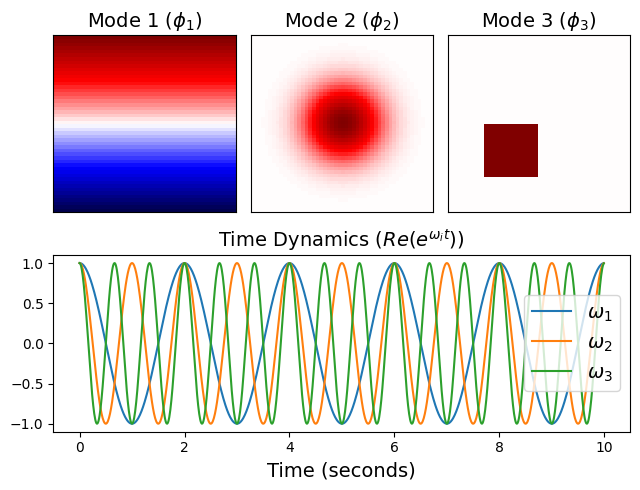

In [3]:
# Plot the data and the true spatiotemporal modes.
fig = plt.figure(figsize=(6.5, 5), dpi=100)
gs = GridSpec(2, 3, figure=fig)

# Plot the spatial modes.
for i, u in enumerate([u1, u2, u3]):
    ax = fig.add_subplot(gs[0, i])
    ax.set_title(f"Mode {i + 1} ($\phi_{i + 1}$)", fontsize=14)
    ax.pcolor(u.reshape(ny, nx), vmax=1, vmin=-1, cmap="seismic")
    ax.set_xticks([])
    ax.set_yticks([])

# Plot the time dynamics.
ax = fig.add_subplot(gs[1, :])
ax.set_title("Time Dynamics ($Re(e^{\omega_i t})$)", fontsize=14)
ax.set_xlabel("Time (seconds)", fontsize=14)
for i, dynamics in enumerate([t1, t2, t3]):
    ax.plot(t, dynamics.real, label=f"$\omega_{i + 1}$", lw=1.5)

plt.legend(loc="right", fontsize=14)
plt.tight_layout()
plt.show()
# plt.savefig("figures/figure-1/true_modes.png", transparent=True)

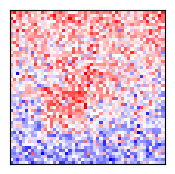

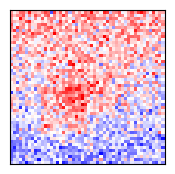

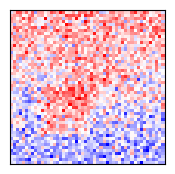

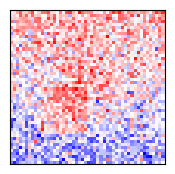

In [4]:
# Plot some frames of the data.
vmax = 1.2 * np.abs(X).max()
for i in [0, 1, 2, nt - 1]:
    plt.figure(figsize=(2, 2), dpi=100)
    plt.pcolor(
        X[:, i].reshape(ny, nx).real,
        vmax=vmax,
        vmin=-vmax,
        cmap="seismic",
    )
    plt.xticks([])
    plt.yticks([])
    plt.show()
    # plt.savefig(f"figures/figure-1/snp_{i + 1}.png", transparent=True)

## Part 2: Apply DMD

In [5]:
# (1) Optimized DMD.
optdmd = BOPDMD(svd_rank=3).fit(X, t)

# (2) Sparse-mode DMD with l1 norm.
optdmd_l1 = SparseBOPDMD(
    svd_rank=3,
    SR3_step=0,
    mode_regularizer="l1",
    regularizer_params={"lambda": 100.0},
).fit(X, t)
optdmd_l1c = SparseBOPDMD(
    svd_rank=3,
    SR3_step=0,
    mode_regularizer="l1",
    regularizer_params={"lambda": 100.0},
    eig_constraints={"imag"},
).fit(X, t)

# (3) Sparse-mode DMD with l0 norm.
optdmd_l0 = SparseBOPDMD(
    svd_rank=3,
    SR3_step=0,
    mode_regularizer="l0",
    regularizer_params={"lambda": 10.0},
).fit(X, t)
optdmd_l0c = SparseBOPDMD(
    svd_rank=3,
    SR3_step=0,
    mode_regularizer="l0",
    regularizer_params={"lambda": 10.0},
    eig_constraints={"imag"},
).fit(X, t)

# (4) Sparse-mode DMD with SR3 + de-biasing.
optdmd_sr3 = SparseBOPDMD(
    svd_rank=3,
    SR3_step=1,
    mode_regularizer="l1",
    regularizer_params={"lambda": 0.1},
    apply_debias=True,
).fit(X, t)

### Part 2 Figures and Videos

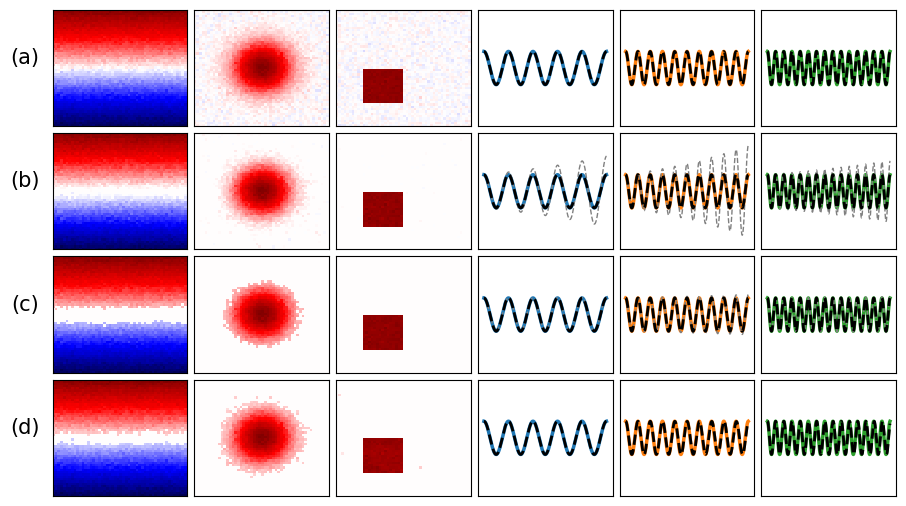

In [6]:
true_colors = ["tab:blue", "tab:orange", "tab:green"]
figure_labels = ["(a)", "(b)", "(c)", "(d)"]
all_models = [optdmd, optdmd_l1, optdmd_l0, optdmd_sr3]
all_models_c = [optdmd_l1c, optdmd_l0c]
c_index = [1, 2]

fig = plt.figure(figsize=(9, 5), dpi=100) # for 1 x 6 plot

# Plot the modes and dynamics for each DMD model.
for model_idx, model in enumerate(all_models):

    # Iterate through the gradient, gaussian, and square.
    for true_idx, dmd_idx in enumerate([0, 2, 1]):

        # Get the current mode and corresponding dynamics.
        mode = model.modes[:, dmd_idx]
        vmax = np.abs(mode).max()
        dynamics = np.exp(model.eigs[dmd_idx] * t)
        true_dynamics = np.exp(true_eigs[true_idx] * t)

        # Plot the DMD mode.
        ax = fig.add_subplot(4, 6, 6 * model_idx + true_idx + 1)
        ax.pcolor(
            mode.reshape(ny, nx).real,
            vmax=vmax,
            vmin=-vmax,
            cmap="seismic",
        )
        ax.set_xticks([])
        ax.set_yticks([])

        if true_idx == 0:
            # Add label to the first mode.
            ax.set_ylabel(figure_labels[model_idx], rotation=0, labelpad=20, fontsize=15)

        # Plot the DMD dynamics against the true dynamics.
        ax = fig.add_subplot(4, 6, 6 * model_idx + true_idx + 4)
        ax.plot(t, true_dynamics, c=true_colors[true_idx], lw=2.5)
        ax.set_ylim([-3.5, 3.5])
        ax.set_xticks([])
        ax.set_yticks([])
        # plt.tight_layout(pad=0.5)

        if model_idx in c_index:
            # For the sparse models, also plot dynamics of the constrained model.
            model_c = all_models_c[c_index.index(model_idx)]
            dynamics_c = np.exp(model_c.eigs[dmd_idx] * t)
            ax.plot(t, dynamics, "--", c="grey", label="No proj.", lw=1)
            ax.plot(t, dynamics_c, "--", c="k", label="With proj.", lw=2)
        else:
            # For regular DMD model, only plot the DMD dynamics.
            ax.plot(t, dynamics, "--", c="k", label="DMD", lw=2)

plt.tight_layout(pad=0.5)
plt.show()
# plt.savefig(f"figures/figure-2/figure-2.png")

In [7]:
models = [optdmd_l1, optdmd_l0, optdmd_sr3]
model_names = [
    "Sparse-mode DMD (FISTA l1)",
    "Sparse-mode DMD (FISTA l0)",
    "Sparse-mode DMD (SR3)",
]

for model, model_name in zip(models, model_names):
    print(f"{model_name} results:")
    print(f"{len(model.operator._obj_history)} variable projection iterations.")

    avg_iter = np.average([len(x) for x in model.operator._obj_history])
    print(f"{avg_iter} mode update iterations on average.")
    print()

Sparse-mode DMD (FISTA l1) results:
13 variable projection iterations.
12.846153846153847 mode update iterations on average.

Sparse-mode DMD (FISTA l0) results:
11 variable projection iterations.
8.272727272727273 mode update iterations on average.

Sparse-mode DMD (SR3) results:
4 variable projection iterations.
4.0 mode update iterations on average.



## Part 3: Compare sparse models

In [8]:
# Choose the lambda values to examine.
lambda_vals = np.linspace(0.01, 0.2, 100) 

# Store model errors and amplitude-scaled modes.
errors = np.empty(len(lambda_vals))
all_modes = []
errors_gl = np.empty(len(lambda_vals))
all_modes_gl = []

# Set the shared model parameters.
model_params = {}
model_params["svd_rank"] = 4
model_params["SR3_step"] = 1
model_params["mode_regularizer"] = "l1"
model_params["apply_debias"] = True

for i, _lambda in tqdm(enumerate(lambda_vals)):
    # Fit model without global-local split.
    optdmd_sparse = SparseBOPDMD(
        regularizer_params={"lambda": _lambda},
        **model_params,
    ).fit(X, t)
    errors[i] = error(optdmd_sparse.reconstructed_data, X_clean)
    all_modes.append(optdmd_sparse.modes.dot(np.diag(optdmd_sparse.amplitudes)))

    # Fit model with global-local split.
    optdmd_gl = SparseBOPDMD(
        regularizer_params={"lambda": _lambda},
        index_global="auto",
        **model_params,
    ).fit(X, t)
    errors_gl[i] = error(optdmd_gl.reconstructed_data, X_clean)
    all_modes_gl.append(optdmd_gl.modes.dot(np.diag(optdmd_gl.amplitudes)))


100it [20:12, 12.12s/it]


### Part 3 Figures and Videos

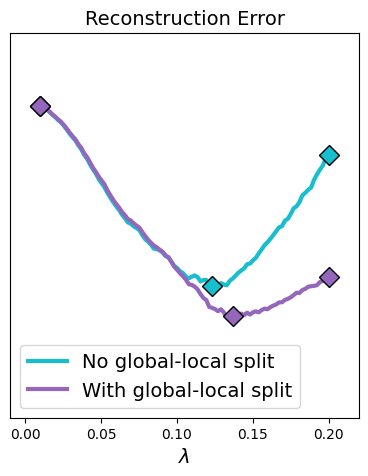

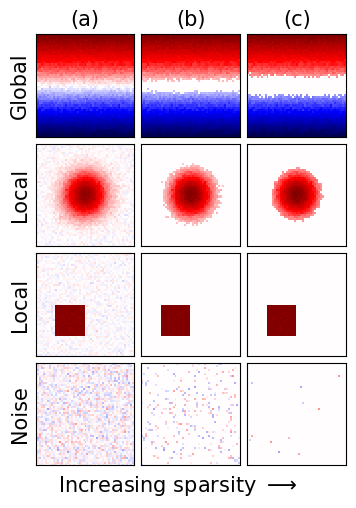

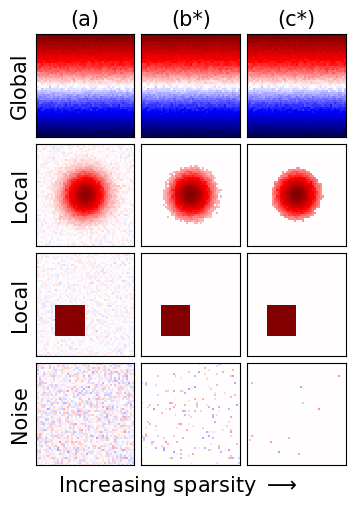

In [9]:
record_idx = [0, np.argmin(errors) - 2, len(lambda_vals) - 1]
record_idx_gl = [0, np.argmin(errors_gl) + 2, len(lambda_vals) - 1]

# (1) Plot error.
plt.figure(figsize=(4.5, 5), dpi=100)
plt.plot(lambda_vals, errors, c="tab:cyan", lw=3, label="No global-local split")
plt.plot(lambda_vals, errors_gl, c="tab:purple", lw=3, label="With global-local split")

for idx in record_idx:
    plt.plot(lambda_vals[idx], errors[idx], "D", mec="k", mfc="tab:cyan", ms=10)

for idx in record_idx_gl:
    plt.plot(lambda_vals[idx], errors_gl[idx], "D", mec="k", mfc="tab:purple", ms=10)

plt.title("Reconstruction Error", fontsize=14)
plt.xlabel("$\lambda$", fontsize=14)
plt.legend(loc="lower left", fontsize=14)
plt.xlim([-0.01, 0.22])
plt.ylim([0.065, 0.14])
plt.yticks([])
plt.show()
# plt.savefig("figures/figure-3/errors.png")

# (2) Plot modes without global-local:
plot_titles = ["(a)", "(b)", "(c)"]
plot_titles_gl = ["(a)", "(b*)", "(c*)"]
plot_labels = ["Global", "Local", "Local", "Noise"]

for k in range(2):
    record_idx_k = [record_idx, record_idx_gl][k]
    all_modes_k = [all_modes, all_modes_gl][k]
    plot_titles_k = [plot_titles, plot_titles_gl][k]

    fig = plt.figure(figsize=(3.5, 5), dpi=100)
    for i, idx in enumerate(record_idx_k):
        mode_set = all_modes_k[idx]
        for j, mode_idx in enumerate([0, 3, 2, 1]):
            mode = mode_set[:, mode_idx]
            plt.subplot(mode_set.shape[1], len(record_idx), len(record_idx) * j + i + 1)
            plt.pcolor(mode.reshape(ny, nx).real, vmax=1, vmin=-1, cmap="seismic")
            plt.xticks([])
            plt.yticks([])
            if j == 0:
                plt.title(plot_titles_k[i], fontsize=15)
            if i == 0:
                plt.ylabel(plot_labels[j], fontsize=15)

    fig.supxlabel("Increasing sparsity $\longrightarrow$", fontsize=15)
    plt.tight_layout(pad=0.5)
    plt.show()
    # plt.savefig(f"figures/figure-3/modes{k + 1}.png")